> 2008年Hinton发表的t-SNE算法论文: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

# 载入iris

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

iris=pd.read_csv('../iris_data/iris.csv') # from R file

In [2]:
iris.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


# demo1

In [3]:
def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist
 

def cal_perplexity(dist, idx=0, beta=1.0):
    '''计算perplexity, D是距离向量，
    idx指dist中自己与自己距离的位置，beta是高斯分布参数
    这里的perp仅计算了熵，方便计算
    '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    perp = np.log(sum_prob) + beta * np.sum(dist * prob) / sum_prob
    prob /= sum_prob
    return perp, prob
 

def seach_prob(x, tol=1e-5, perplexity=30.0):
    '''二分搜索寻找beta,并计算pairwise的prob
    '''
    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)
 
    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))
 
        betamin = -np.inf
        betamax = np.inf
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])
 
        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
 
            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    return pair_prob
 

def pca(x, no_dims = 50):
    ''' PCA算法
    使用PCA先进行预降维
    '''
    print("Preprocessing the data using PCA...")
    (n, d) = x.shape
    x = x - np.tile(np.mean(x, 0), (n, 1))
    l, M = np.linalg.eig(np.dot(x.T, x))
    y = np.dot(x, M[:,0:no_dims])
    return y
 

def tsne(x, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    """Runs t-SNE on the dataset in the NxD array x
    to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(x, no_dims, perplexity),
    where x is an NxD NumPy array.
    """
 
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
 
    # 初始化参数和变量
    x = pca(x, initial_dims).real
    (n, d) = x.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    y = np.random.randn(n, no_dims)
    dy = np.zeros((n, no_dims))
    iy = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
 
    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    # early exaggeration
    P = P * 4
    P = np.maximum(P, 1e-12)
 
    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
 
        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)
 
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dy > 0) != (iy > 0)) + (gains * 0.8) * ((dy > 0) == (iy > 0))
        gains[gains < min_gain] = min_gain
        iy = momentum * iy - eta * (gains * dy)
        y = y + iy
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            if iter > 100:
                C = np.sum(P * np.log(P / Q))
            else:
                C = np.sum( P/4 * np.log( P/4 / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    print("finished training!")
    return y

Preprocessing the data using PCA...
Computing pairwise distances...
Computing pair_prob for point 0 of 150 ...
Mean value of sigma:  1.020099563325348
Iteration  100 : error is  0.6405484751488213
Iteration  200 : error is  0.06877183147047794
Iteration  300 : error is  0.06837387955066673
Iteration  400 : error is  0.06831653226380013
Iteration  500 : error is  0.0683058212716347
Iteration  600 : error is  0.06830313546409417
Iteration  700 : error is  0.06830248117743731
Iteration  800 : error is  0.06830231147579871
finished training!


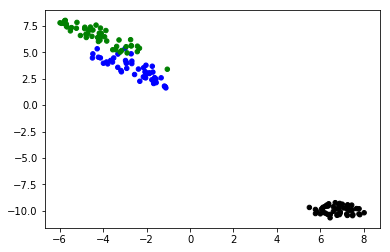

In [4]:
#if __name__ == "__main__":
# Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
X = iris.iloc[:,1:5] #np.loadtxt("mnist2500_X.txt")

#labels = iris.iloc[:,5:6] #np.loadtxt("mnist2500_labels.txt")
lables=['black']*50+['blue']*50+ ['green']*50;

Y = tsne(X, 2, 50, 50.0, 800)
plt.scatter(Y[:,0], Y[:,1], 20, color=lables)
plt.show()

## 不懂的线性代数

In [11]:
a=np.array([[0,1,2],[3,4,5], [6,7,8]])
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [12]:
np.sum(a,1)

array([ 3, 12, 21])

In [13]:
np.square(a)

array([[ 0,  1,  4],
       [ 9, 16, 25],
       [36, 49, 64]])

In [14]:
X=a

In [15]:
sum_X = np.sum(np.square(X), 1)
sum_X

array([  5,  50, 149])

In [16]:
# D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

In [17]:
X.T

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [18]:
-2*np.dot(X, X.T)

array([[ -10,  -28,  -46],
       [ -28, -100, -172],
       [ -46, -172, -298]])

In [19]:
np.add(-2 * np.dot(X, X.T), sum_X)

array([[  -5,   22,  103],
       [ -23,  -50,  -23],
       [ -41, -122, -149]])

In [20]:
np.add(-2 * np.dot(X, X.T), sum_X).T

array([[  -5,  -23,  -41],
       [  22,  -50, -122],
       [ 103,  -23, -149]])

In [21]:
D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
D

array([[  0,  27, 108],
       [ 27,   0,  27],
       [108,  27,   0]])

### test

In [22]:
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [23]:
np.max(X, axis=1)

array([2, 5, 8])

In [24]:
np.max(X, axis=1).reshape([-1, 1])

array([[2],
       [5],
       [8]])

In [25]:
X.reshape([-1, 1])

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [26]:
X - np.max(X, axis=1).reshape([-1, 1])

array([[-2, -1,  0],
       [-2, -1,  0],
       [-2, -1,  0]])

In [27]:
np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

array([[0.13533528, 0.36787944, 1.        ],
       [0.13533528, 0.36787944, 1.        ],
       [0.13533528, 0.36787944, 1.        ]])

In [28]:
np.exp(-2)

0.1353352832366127

### divide

In [29]:
e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
e_x

array([[0.13533528, 0.36787944, 1.        ],
       [0.13533528, 0.36787944, 1.        ],
       [0.13533528, 0.36787944, 1.        ]])

In [30]:
e_x = e_x + 1e-8  # numerical stability
e_x

array([[0.13533529, 0.36787945, 1.00000001],
       [0.13533529, 0.36787945, 1.00000001],
       [0.13533529, 0.36787945, 1.00000001]])

In [31]:
e_x / e_x.sum(axis=1).reshape([-1, 1])

array([[0.09003058, 0.24472847, 0.66524095],
       [0.09003058, 0.24472847, 0.66524095],
       [0.09003058, 0.24472847, 0.66524095]])

In [32]:
X.shape

(3, 3)

In [33]:
#len(np.array())
y=np.array([x for x in range(12)])
print(y)
y=y.reshape((2,6))
print(y)
len(y)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]]


2

In [34]:
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [35]:
np.expand_dims(X, 0)

array([[[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]])

In [36]:
np.expand_dims(X, 1)

array([[[0, 1, 2]],

       [[3, 4, 5]],

       [[6, 7, 8]]])

In [37]:
np.expand_dims(X, 2)

array([[[0],
        [1],
        [2]],

       [[3],
        [4],
        [5]],

       [[6],
        [7],
        [8]]])

In [38]:
np.expand_dims(X, 1)

array([[[0, 1, 2]],

       [[3, 4, 5]],

       [[6, 7, 8]]])

In [39]:
np.expand_dims(X, 1).shape

(3, 1, 3)

In [40]:
print(np.expand_dims(X, 1)[0])
np.expand_dims(X, 1)[0][0]

[[0 1 2]]


array([0, 1, 2])

In [41]:
np.expand_dims(X, 0)

array([[[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]])

In [42]:
np.expand_dims(X, 0).shape

(1, 3, 3)

In [43]:
np.expand_dims(X, 1) - np.expand_dims(X, 0)

array([[[ 0,  0,  0],
        [-3, -3, -3],
        [-6, -6, -6]],

       [[ 3,  3,  3],
        [ 0,  0,  0],
        [-3, -3, -3]],

       [[ 6,  6,  6],
        [ 3,  3,  3],
        [ 0,  0,  0]]])

In [44]:
(np.expand_dims(X, 1) - np.expand_dims(X, 0)).shape

(3, 3, 3)

In [45]:
np.array( range(24) ).reshape((2,3,4))

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

# demo 2 （支持多维输出）

In [5]:
"""
Functions to fit Symmetric SNE and t-SNE
Author: Liam Schoneveld
"""

import numpy as np
#from categorical_scatter import categorical_scatter_2d


def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X
    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


def softmax(X, diag_zero=True, zero_index=None):
    """Compute softmax values for each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    if zero_index is None:
        if diag_zero:
            np.fill_diagonal(e_x, 0.)
    else:
        e_x[:, zero_index] = 0.

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])


def calc_prob_matrix(distances, sigmas=None, zero_index=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq, zero_index=zero_index)
    else:
        return softmax(distances, zero_index=zero_index)


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess


def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row
    of a matrix of probabilities."""
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas, zero_index):
    """Wrapper function for quick calculation of
    perplexity over a distance matrix."""
    return calc_perplexity(
        calc_prob_matrix(distances, sigmas, zero_index))


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma), i)
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])


def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None


def symmetric_sne_grad(P, Q, Y, _):
    """Estimate the gradient of the cost with respect to Y"""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad


def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances


def tsne_grad(P, Q, Y, distances):
    """t-SNE: Estimate the gradient of the cost with respect to Y."""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  # NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # NxNx2
    # Expand our distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(distances, 2)  # NxNx1
    # Weight this (NxNx2) by distances matrix (NxNx1)
    y_diffs_wt = y_diffs * distances_expanded  # NxNx2
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)  # Nx2
    return grad


def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.
    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P


def estimate_sne(X, y, P, rng, num_iters, q_fn, grad_fn, learning_rate,
                 momentum, plot, distDim=2):
    """Estimates a SNE model.
    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation Or more-D
    Y = rng.normal(0., 0.0001, [X.shape[0], distDim]) #---->>>>>指定输出维数

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_fn(Y)
        # Estimate gradients with respect to Y
        grads = grad_fn(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

        # Plot sometimes
        if plot and i % (num_iters / plot) == 0:
            categorical_scatter_2d(Y, y, alpha=1.0, ms=6,
                                   show=True, figsize=(9, 6))

    return Y

In [6]:
X=np.array(iris.iloc[:, 1:5])

X= X / np.sum(X,axis=1).reshape((-1,1))
X[1:10]

array([[0.51578947, 0.31578947, 0.14736842, 0.02105263],
       [0.5       , 0.34042553, 0.13829787, 0.0212766 ],
       [0.4893617 , 0.32978723, 0.15957447, 0.0212766 ],
       [0.49019608, 0.35294118, 0.1372549 , 0.01960784],
       [0.47368421, 0.34210526, 0.14912281, 0.03508772],
       [0.4742268 , 0.35051546, 0.1443299 , 0.03092784],
       [0.4950495 , 0.33663366, 0.14851485, 0.01980198],
       [0.49438202, 0.3258427 , 0.15730337, 0.02247191],
       [0.51041667, 0.32291667, 0.15625   , 0.01041667]])

(150, 4)


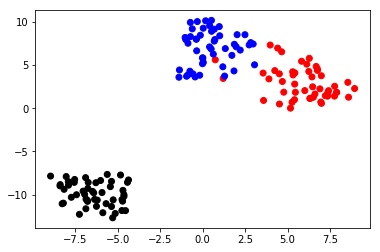

In [7]:
X=np.array(iris.iloc[:, 1:5])
X= X / np.sum(X,axis=1).reshape((-1,1))
#
target_perplexity= 30 #np.array( [30]*150)
print(X.shape) #(150, 4)
#print(target_perplexity.shape) #(150,)

P=p_joint(X, target_perplexity)

rng=np.random.RandomState()
endY=estimate_sne(X, iris.Species,   P, rng, num_iters=800, q_fn=q_tsne, grad_fn=tsne_grad, learning_rate=100,
                 momentum=None, plot=False)
"""Estimates a SNE model.
# Arguments
    X: Input data matrix.
    y: Class labels for that matrix.
    P: Matrix of joint probabilities.
    rng: np.random.RandomState().
    num_iters: Iterations to train for.
    q_fn: Function that takes Y and gives Q prob matrix.
    plot: How many times to plot during training.
# Returns:
    Y: Matrix, low-dimensional representation of X.
"""
colors=['black']*50+['red']*50+['blue']*50
plt.scatter(endY.T[0], endY.T[1], color=colors )

In [8]:
rng.normal(0., 1, [5, 2]) # 产生二维随机数

array([[ 0.01577137,  0.93738262],
       [ 1.05859554,  0.81172161],
       [ 0.30246135, -1.33225555],
       [-0.36814364, -0.46832719],
       [-0.16429799, -0.42132067]])

In [11]:
# 二分查找
def f1(x):
    return(np.sin(x))

rs=binary_search(f1, 0.5, tol=1e-10, max_iter=10000, lower=0, upper=3.)
rs/3.1415926*180

30.000000509472514

## 输出三维

(150, 4)


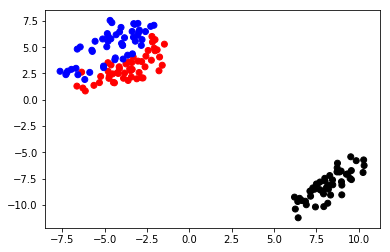

In [12]:
X=np.array(iris.iloc[:, 1:5])
X= X / np.sum(X,axis=1).reshape((-1,1))
#
target_perplexity= 30 #np.array( [30]*150)
print(X.shape) #(150, 4)
#print(target_perplexity.shape) #(150,)

P=p_joint(X, target_perplexity)

rng=np.random.RandomState()
endY=estimate_sne(X, iris.Species,   P, rng, num_iters=800, q_fn=q_tsne, grad_fn=tsne_grad, learning_rate=100,
                 momentum=None, plot=False, distDim=3)
"""Estimates a SNE model.
# Arguments
    X: Input data matrix.
    y: Class labels for that matrix.
    P: Matrix of joint probabilities.
    rng: np.random.RandomState().
    num_iters: Iterations to train for.
    q_fn: Function that takes Y and gives Q prob matrix.
    plot: How many times to plot during training.
# Returns:
    Y: Matrix, low-dimensional representation of X.
"""
colors=['black']*50+['red']*50+['blue']*50
plt.scatter(endY.T[0], endY.T[1], color=colors )

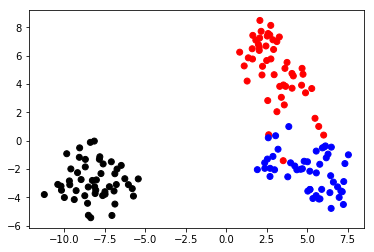

In [13]:
plt.scatter(endY.T[1], endY.T[2], color=colors )

In [21]:
help(ax1.view_init)

Help on method view_init in module mpl_toolkits.mplot3d.axes3d:

view_init(elev=None, azim=None) method of matplotlib.axes._subplots.Axes3DSubplot instance
    Set the elevation and azimuth of the axes.
    
    This can be used to rotate the axes programmatically.
    
    'elev' stores the elevation angle in the z plane.
    'azim' stores the azimuth angle in the x,y plane.
    
    if elev or azim are None (default), then the initial value
    is used which was specified in the :class:`Axes3D` constructor.



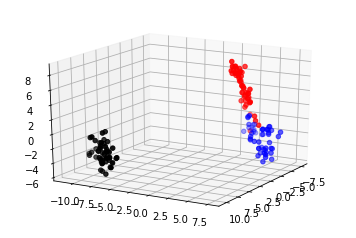

In [29]:
# https://blog.csdn.net/u014636245/article/details/82799573
# https://stackoverflow.com/questions/56222259/valueerror-unknown-projection-3d-once-again

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting

fig = plt.figure()
ax1 = fig.gca(projection='3d')

#ax1 = plt.axes(projection='3d')
ax1.scatter3D(endY.T[0],endY.T[1],endY.T[2], color=colors )  #绘制散点图
# ax1.scatter3D(endY.T[0],endY.T[1],endY.T[2], cmap='Blues')  #绘制散点图
# ax1.plot3D(endY.T[0],endY.T[1],endY.T[2],'gray')    #绘制空间曲线

ax1.view_init(elev=20,azim=30)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
plt.show()

# sklearn

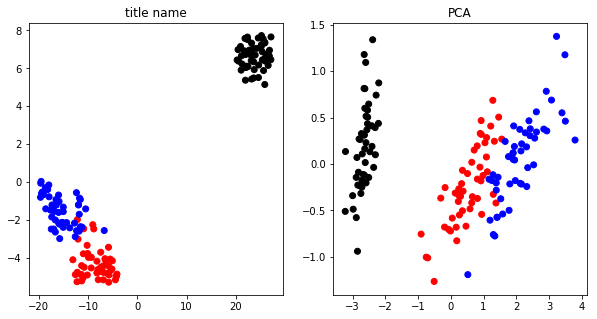

In [32]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
# iris = load_iris()
iris.data=iris.iloc[:, 1:5]
iris.target=['black']*50+['red']*50+['blue']*50
#
X_tsne = TSNE(learning_rate=100).fit_transform(iris.data)
X_pca = PCA().fit_transform(iris.data)


# plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=iris.target)
#plt.title('tSNE')
plt.title('title name')
#
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target)
plt.title("PCA")
plt.show()

In [33]:
np.square([-1j, 1j])

array([-1.+0.j, -1.+0.j])